In [1]:
from igraph import *
import networkx as nx
import random
import louvain
import os,sys
import time
import subprocess
from infomap import Infomap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/home/alphaq2/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  after removing the cwd from sys.path.


In [2]:

def clique(g, size, idx, num_nodes):
  for i in range(idx,num_nodes-1):
    for j in range(idx - size,idx):
      g[i,j] = 0

In [3]:
def Print(g,num_nodes):
  G = nx.Graph()
  for i in range(num_nodes):
    G.add_node(i)
  for i in range(num_nodes):
    for j in range(i+1, num_nodes):
      if g[i,j] == 1:
        G.add_edge(i,j)
  nx.draw(G, with_labels=True)

In [4]:
def walktrap(g):
  k = g.community_walktrap()
  k = k.as_clustering()
  print(k)

In [5]:
def infomap(g):
  k = g.community_infomap()
  print(k)

In [6]:
def hub_node(clq):
    num_nodes = int((clq*(clq+1))/2) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [7]:
def hub_node2(clq):
    num_nodes = int(clq*(clq+1)) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
        size = size + i
        clique(g,i,size,num_nodes)
    g[num_nodes-2, num_nodes-3] = 0
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [8]:
def alt_hub_node(clq):
    num_nodes = int((clq+1)*(clq+1)/4) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-2):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [9]:
def creat_random_connected(offset,size,number_of_edges = 100000000):

    edges = []
    for i in range(size-1):
        edges.append((offset + i,offset + i + 1))
    edges.append((offset,offset + size - 1))
    ret_edges = edges[:];
    
    edges = []
    for i in range(size):
        for j in range(i + 1,size):
            if((offset + i,offset + j) not in ret_edges):
                edges.append((offset + i,offset + j))

    last = len(edges)-1
    for i in range(min(number_of_edges,len(edges))):
        ind = random.randint(0,last)
        ret_edges.append(edges[ind])
        tmp = edges[ind]
        edges[ind] = edges[last]
        edges[last] = tmp
        last -= 1
    return ret_edges

In [10]:
def ring_of_clique(ring_size , clique_size):

    total_vert = ring_size*clique_size;

    edges = creat_random_connected(0,clique_size);import random

    offset = clique_size
    prev_connector = offset - 1

    for i in range(ring_size - 1):
        new_clique = creat_random_connected(offset,clique_size);
        new_clique.append((prev_connector,offset))
        edges.extend(new_clique)
        offset += clique_size
        prev_connector += clique_size

    edges.append((0,prev_connector))

    return [total_vert, edges]


In [11]:
def line_star_graph(total_vert, line_length):
    edges = []

    for i in range(1,line_length):
        edges.append((i-1,i))

    middle_node = line_length//2
    rem_vert = total_vert - line_length
    offset = line_length

    for i in range(rem_vert):
        edges.append((middle_node,offset + i))

    return [total_vert, edges]

In [12]:
def run_louvain(total_vert,edges):
                
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    
#     Print(g,total_vert)
    
    part = louvain.find_partition(g, louvain.ModularityVertexPartition);
#     print(part)
    return part

In [13]:
def run_maxperm(total_vert, edges):
    
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    
    input_file = open("input.dat", "w")
    input_file.write(str(g.vcount()) + " " + str(g.ecount()) + "\n")
    for i in g.es:
        m1 = i.tuple[0]
        m2 = i.tuple[1]
        input_file.write(str(m1) + " " + str(m2) + "\n")
#         input_file.write(str(m2) + " " + str(m1) + "\n")
    input_file.close()
    
    returned_value = subprocess.check_output("bash compile.sh", shell = True)
    returned_value = returned_value.decode("utf-8")
    
    #print(returned_value)
    
    output_file = open("output.txt","r")
    partitions = output_file.readlines() 

    dicti={}
    for line in partitions[2:]:
        #print(line.strip())
        pair = line.split('\t')
        pair = list(map(int,pair))
        if pair[1] in dicti:
            dicti[pair[1]].append(pair[0])
        else:
            dicti[pair[1]] = [pair[0]]
    
#     print("total partitions : " + str(len(dicti.keys())) )
#     for i in dicti.keys():
#         print ("[" + str(i) + "] : "),
#         print(list(dicti[i]))
    return dicti
    

In [14]:
def hub_surr_cliq(total_number_of_cliq,list_of_sizes):
    
    total_vert = sum(list_of_sizes) + 1
    offset = 1
    edges = []
    
    for i in range(total_number_of_cliq):
        edges.append((0,offset))
        edges.extend(creat_random_connected(offset,list_of_sizes[i]))
        offset += list_of_sizes[i]
        
    return [total_vert,edges]
def hub_surr_cliq2(total_number_of_cliq,list_of_sizes):
    
    total_vert = sum(list_of_sizes) + 1
    offset = 1
    edges = []
    for i in range(1,total_vert):
        edges.append((0,i))
    for i in range(total_number_of_cliq):
        edges.append((0,offset))
        edges.extend(creat_random_connected(offset,list_of_sizes[i]))
        offset += list_of_sizes[i]
        
    return [total_vert,edges]


In [15]:
def comm_surr_comm(middle_size,outer_size,count_outer,beta):
    edges = []

    if(middle_size < count_outer):
        print "add more vertices to middle comm"
        return None

    g = Graph()
    total_vert = count_outer*outer_size + middle_size
    g.add_vertices(total_vert)

    edges.extend(creat_random_connected(0,middle_size))
    
    offset = middle_size
    for i in range(count_outer):
        edges.extend(creat_random_connected(offset,outer_size))
        beta1 = beta
        for j in range(offset,offset + outer_size):
            if(beta1 == 0):
                break
            beta1 -= 1
            edges.append((i,j))
        offset += outer_size

    return [total_vert,edges]


In [16]:
def hub_node_graph(left_size,right_size):
    edges = []

#     g = Graph()
    total_vert = left_size + right_size + 1
#     g.add_vertices(total_vert)
    
    hub_node = 0
    offset_right = left_size + 1
    
    edges.extend(creat_random_connected(0,left_size + 1))
    edges.extend(creat_random_connected(offset_right,right_size))

    for i in range(right_size):
        edges.append((0,offset_right + i));
#     print(edges)
#     g.add_edges(edges)
    return [total_vert, edges]


In [17]:
def ring_of_clique_temp(ring_size , clique_list):

    total_vert = sum(clique_list);

    edges = creat_random_connected(0,clique_list[0]);

    offset = clique_list[0]
    prev_connector = offset - 1

    for i in range(1,ring_size):
        new_clique = creat_random_connected(offset,clique_list[i]);
        new_clique.append((prev_connector,offset))
        edges.extend(new_clique)
        offset += clique_list[i]
        prev_connector += clique_list[i]

    edges.append((0,prev_connector))

    return [total_vert, edges]

In [18]:
def run_infomap(total_vert,edges):
    im = Infomap("--two-level --directed")
#     im.add_link(0, 1)
    for i in edges:
        im.addLink(i[0],i[1])
        im.addLink(i[1],i[0])
    im.run()
    sets = {}

#     print("Found " + str(im.num_top_modules)+ " modules with codelength: " + str(im.codelength))
    print("Result")
    print("\n#node module")
    for node in im.tree:
        if node.is_leaf:
            if(node.module_id in sets):
                sets[node.module_id].append(node.node_id)
            else:
                sets[node.module_id] = [node.node_id]
            print(node.node_id, node.module_id)
    print("total partitions : " + str(len(sets.keys())) )
    for i in sets.keys():
        print ("[" + str(i) + "] : "),
        print(sets[i])
        
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    Print(g,total_vert)

In [19]:
def hub_node_generic(x,y,alpha,beta):
    total_vert = x + y + 1 + alpha + beta;
    x,y = y,x
    alpha,beta = beta,alpha
    x = x + alpha
    y = y + beta
    edges = creat_random_connected(1,y);
    offset = y + 1;
    edges.extend(creat_random_connected(offset,x));

    for i in range(1,y + 1):
        if(beta == 0):
            break
        edges.append((0,i))
        beta -= 1
    for i in range(y + 1,y + x + 1):
        if(alpha == 0):
            break
        edges.append((0,i))
        alpha -= 1

    return [total_vert, edges]

# Hub Node (generic)

## Modularity

### CASE 1: Varying x and y  (btw 5 - 24) with constant alpha = 10 and beta = 10

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

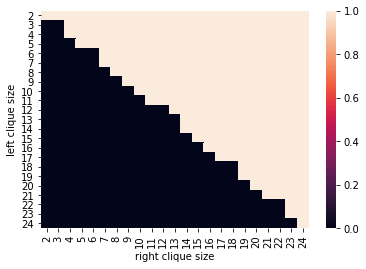

In [20]:
x_val = [i for i in range(2,25)]
y_val = [i for i in range(2,25)]
alpha = 10
beta = 10
matrix_ans = []
for i in x_val:
    temp = []
    for j in y_val:
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("right clique size")
plt.ylabel("left clique size")
plt.show()

### CASE 2: Varying alpha and beta (btw 5 -24) with constant x = 50 and y = 50

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

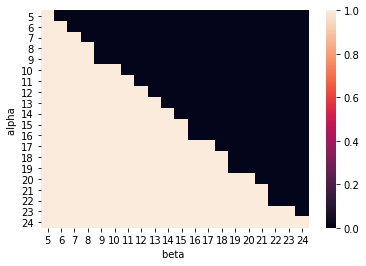

In [21]:
alpha_val = [i for i in range(5,25)]
beta_val = [i for i in range(5,25)]
x = 50
y = 50
matrix_ans = []
for alpha in alpha_val:
    temp = []
    for beta in beta_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=alpha_val)
plt.xlabel("beta ")
plt.ylabel("alpha ")
plt.show()

### CASE 3: Varying alpha and x  with constant y = 50 and beta = 10

x : 5 10 .. 100 

alpha : 5 - 50

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

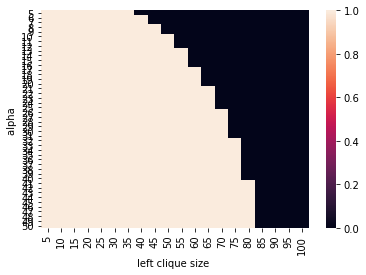

In [23]:
alpha_val = [i for i in range(5,51)]
x_val = [i*5 for i in range(1,21)]
beta = 10
y = 50
matrix_ans = []
for alpha in alpha_val:
    temp = []
    for x in x_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=alpha_val)
plt.xlabel("left clique size ")
plt.ylabel("alpha ")
plt.show()

## Maxperm

### CASE 1: Varying x and y  (btw 5 - 20) with constant alpha = 20 and beta = 20

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

In [ ]:
x_val = [i for i in range(5,20)]
y_val = [i for i in range(5,20)]
alpha = 7
beta = 7
matrix_ans = []
for i in x_val:
    print i,
    temp = []
    for j in y_val:
#         print j,
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        for i in part.keys():
            if(0 in part[i]):
                if(1 in part[i]):
                    temp.append(1)
                else:
                    temp.append(0)
                break
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("right clique size")
plt.ylabel("left clique size")
plt.show()

 5

In [ ]:
x_val = [i for i in range(5,25)]
y_val = [i for i in range(5,25)]
alpha = 3
beta = 3
matrix_ans = []
for i in x_val:
    temp = []
    for j in y_val:
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
#         print(i,j,part)
        if(len(part) == 1):
            temp.append(2)
            continue;
        for i in part.keys():
            if(0 in part[i]):
                if(1 in part[i]):
                    temp.append(1)
                else:
                    temp.append(0)
                break
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("right clique size")
plt.ylabel("left clique size")
plt.show()

### CASE 2: Varying alpha and beta (btw 5 -24) with constant x = 30 and y = 30

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

In [ ]:
alpha_val = [i for i in range(5,25)]
beta_val = [i for i in range(5,25)]
x = 30
y = 30
matrix_ans = []
for alpha in alpha_val:
    temp = []
    for beta in beta_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part.keys()) == 1):
            temp.append(2)
            continue;
        for i in part.keys():
            if(0 in part[i]):
                if(1 in part[i]):
                    temp.append(1)
                else:
                    temp.append(0)
                break
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=alpha_val)
plt.xlabel("beta ")
plt.ylabel("alpha ")
plt.show()

### CASE 3: Varying alpha and x  with constant y = 30 and beta = 7

x : 5 10 .. 75 

alpha : 5 - 30

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

In [ ]:
alpha_val = [i for i in range(1,31)]
x_val = [i*5 for i in range(1,16)]
beta = 7
y = 30
matrix_ans = []
for alpha in alpha_val:
    print alpha,
    temp = []
    for x in x_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part.keys()) == 1):
            temp.append(2)
            continue;
        for i in part.keys():
            if(0 in part[i]):
                if(1 in part[i]):
                    temp.append(1)
                else:
                    temp.append(0)
                break
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=alpha_val)
plt.xlabel("left clique size ")
plt.ylabel("alpha ")
plt.show()

# Ring of Cliques

## Modularity

x : between 55 , 60 ... 100, total ring size 

y : between 3 - 30, each clique size

1 => Some of the cliques were merged together

0 => None of the cliques were merged together

2 => not even those small cliques were identified correctly

In [ ]:
x_val = [i*5 for i in range(5,21)]
y_val = [i for i in range(3,31)]
matrix_ans = []
for x in x_val:
    temp = []
    for y in y_val:
        graph = ring_of_clique(x,y)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("each clique size ")
plt.ylabel("total ring size ")
plt.show()

In [ ]:
x_val = [i for i in range(30,71)]
y_val = [i for i in range(5,31)]
matrix_ans = []
for x in x_val:
    temp = []
    for y in y_val:
        graph = ring_of_clique(x,y)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("each clique size ")
plt.ylabel("total ring size ")
plt.show()

## Maxperm

x : between 55 , 60 ... 100, total ring size 

y : between 3 - 30, each clique size

1 => Some of the cliques were merged together

0 => None of the cliques were merged together

2 => not even those small cliques were identified correctly

In [ ]:
x_val = [i*5 for i in range(10,21)]
y_val = [i for i in range(3,31)]
matrix_ans = []
for x in x_val:
    temp = []
    for y in y_val:
        graph = ring_of_clique(x,y)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("each clique size ")
plt.ylabel("total ring size ")
plt.show()

# One clique surrounded by others(Generalized)

## Modularity

### CASE 1 varying x and y

x : between 30,35 ... 100, total ring size 

y : between 7 - 30, each clique size

alpha : 10, number of outer cliques

beta : 7, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
x_val = [i*5 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 10
beta = 7
matrix_ans = []
for x in x_val:
    temp = []
    for y in y_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("each outer clique size ")
plt.ylabel("main clique size ")
plt.show()

In [ ]:
x_val = [i*5 for i in range(6,35)]
y_val = [i for i in range(15,41)]
alpha = 10
beta = 15
matrix_ans = []
for x in x_val:
    temp = []
    for y in y_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("each outer clique size ")
plt.ylabel("main clique size ")
plt.show()

### CASE 2 varying alpha and beta

x : 100, total ring size 

y : 10, each clique size

alpha : 2 - 30, number of outer cliques

beta : 1 - 10, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
alpha_val = [i for i in range(2,30)]
beta_val = [i for i in range(1,10)]
x = 100
y = 10
matrix_ans = []
for alpha in alpha_val:
    temp = []
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
#         print(part,flag)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=alpha_val)
plt.xlabel("beta ")
plt.ylabel("alpha ")
plt.show()

### CASE 3 varying x and beta

alpha : 15, total ring size 

y : 30, each clique size

x : 15 - 50, inner clique size

beta : 1 - 30, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
x_val = [i for i in range(15,50)]
beta_val = [i for i in range(1,30)]
alpha = 15
y = 30
matrix_ans = []
for x in x_val:
    temp = []
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=x_val)
plt.xlabel("beta ")
plt.ylabel("main clique size ")
plt.show()

### CASE 4 varying y and beta

alpha : 20, total ring size 

y : 20 - 40, each clique size

x : 15, inner clique size

beta : 1 - 20, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
y_val = [i for i in range(20,40)]
beta_val = [i for i in range(1,20)]
alpha = 10
x = 15
matrix_ans = []
for y in y_val:
    temp = []
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
#         if(y == 31):
#             print(part)
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
#             print(x,y,alpha,beta,flag)
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=y_val)
plt.xlabel("beta ")
plt.ylabel("each outer clique size ")
plt.show()

In [ ]:
graph = comm_surr_comm(15,31,10,11)
part = run_louvain(graph[0],graph[1])
print(part)

## Maxperm

### CASE 1 varying x and y

x : between 30,35 ... 100, total ring size 

y : between 7 - 30, each clique size

alpha : 10, number of outer cliques

beta : 7, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
x_val = [i*3 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 10
beta = 7
matrix_ans = []
for x in x_val:
    temp = []
    for y in y_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=y_val, yticklabels=x_val)
plt.xlabel("each outer clique size ")
plt.ylabel("main clique size ")
plt.show()

### CASE 2 varying alpha and beta

x : 100, total ring size 

y : 10, each clique size

alpha : 2 - 30, number of outer cliques

beta : 1 - 10, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
alpha_val = [i for i in range(2,30)]
beta_val = [i for i in range(1,10)]
x = 60
y = 10
matrix_ans = []
for alpha in alpha_val:
    temp = []
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
#         print(part,flag)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=alpha_val)
plt.xlabel("beta ")
plt.ylabel("alpha ")
plt.show()

### CASE 3 varying x and beta

alpha : 15, total ring size 

y : 30, each clique size

x : 15 - 50, inner clique size

beta : 1 - 30, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
x_val = [i for i in range(15,50)]
beta_val = [i for i in range(1,30)]
alpha = 15
y = 30
matrix_ans = []
for x in x_val:
    temp = []
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=x_val)
plt.xlabel("beta ")
plt.ylabel("main clique size ")
plt.show()

### CASE 4 varying y and beta

alpha : 20, total ring size 

y : 20 - 40, each clique size

x : 15, inner clique size

beta : 1 - 20, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

In [ ]:
y_val = [i for i in range(20,40)]
beta_val = [i for i in range(1,20)]
alpha = 10
x = 15
matrix_ans = []
for y in y_val:
    temp = []
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=y_val)
plt.xlabel("beta ")
plt.ylabel("each outer clique size ")
plt.show()

# Karate Club dataset

## Modularity

In [ ]:

G = nx.karate_club_graph()
karate = load("karate.gml")
# print(karate)
edges = []
for i in G.edges():
    source = i[0]
    dest = i[1]
#     print(source,dest)
    edges.append((source,dest))

part = run_louvain(34,edges)
print("LOUVAIN")
print(part)
circ_pos = nx.circular_layout(G)
nx.draw_circular(G, with_labels=True)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[0], node_color='g', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[1], node_color='r', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[2], node_color='b', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[3], node_color='orange', alpha=0.5)
plt.show()

## Maxperm

In [ ]:
plt.close()
part = run_maxperm(34,edges)
circ_pos = nx.circular_layout(G)
nx.draw_circular(G, with_labels=True)
print("MAXPERM")
for i in part:
    print i,": ",
    print(sorted(list(part[i])))
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[16]), node_color='green', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[32]), node_color='r', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[10]), node_color='blue', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[25]), node_color='black', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[12]), node_color='pink', alpha=0.5)
plt.show()